In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image

In [2]:
def load_dataset():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) 
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) 
    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) 
    classes = np.array(test_dataset["list_classes"][:]) 
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [0], it's a 'non-cat' picture.


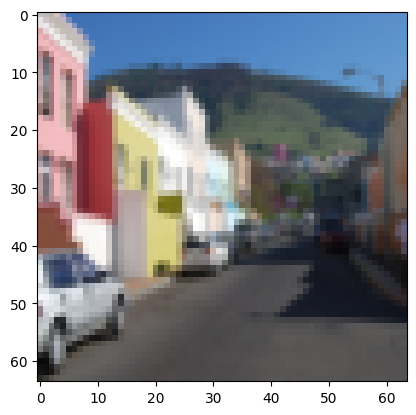

In [4]:
index = 1
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

Завдання 1

In [6]:
def get_dataset_info(dataset):
    """
    Extracts size information from the dataset.
    
    Args:
    dataset (np.array): The dataset from which to extract size information.
    
    Returns:
    tuple: The number of examples, the pixel dimension of the images, and the shape of the dataset.
    """
    num_examples = dataset.shape[0]
    pixel_dim = dataset.shape[1]
    return num_examples, pixel_dim, dataset.shape

m_train, num_px, train_shape = get_dataset_info(train_set_x_orig)
m_test, _, test_shape = get_dataset_info(test_set_x_orig)

print(f"Number of training examples: m_train = {m_train}")
print(f"Number of testing examples: m_test = {m_test}")
print(f"Height/Width of each image: num_px = {num_px}")
print(f"Each image is of size: ({num_px}, {num_px}, 3)")
print(f"train_set_x shape: {train_shape}")
print(f"train_set_y shape: {train_set_y.shape}")
print(f"test_set_x shape: {test_shape}")
print(f"test_set_y shape: {test_set_y.shape}")


Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


Завдання 2

In [7]:
def flatten_dataset(x_orig):
    """
    Reshape the original dataset from (num_samples, height, width, depth)
    to (height*width*depth, num_samples).
    """
    num_samples = x_orig.shape[0]
    return x_orig.reshape(num_samples, -1).T

train_set_x_flatten = flatten_dataset(train_set_x_orig)
test_set_x_flatten = flatten_dataset(test_set_x_orig)

print("train_set_x_flatten shape:", train_set_x_flatten.shape)
print("train_set_y shape:", train_set_y.shape)
print("test_set_x_flatten shape:", test_set_x_flatten.shape)
print("test_set_y shape:", test_set_y.shape)
print("Sanity check after reshaping:", train_set_x_flatten[0:5, 0])


train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
Sanity check after reshaping: [17 31 56 22 33]


Завдання 3

In [10]:
def robust_sigmoid(z):
    """
    Compute the sigmoid of z using a method that avoids overflow and underflow.
    Adds handling for large scale input to maintain stability.

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    
    if isinstance(z, np.ndarray):
        
        z = np.clip(z, -500, 500)  
    elif isinstance(z, (int, float)):
        z = max(min(z, 500), -500)
    s = 1 / (1 + np.exp(-z))
    return s


In [12]:
print ("sigmoid([0, 2]) = " + str(robust_sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


Завдання 4

In [13]:
def initialize_with_options(dim, init_type='zeros'):
    """
    Creates an initialization vector and a bias scalar based on the specified initialization type.
    
    Arguments:
    dim -- size of the w vector we want (number of parameters)
    init_type -- type of initialization ('zeros', 'ones', 'random'), default is 'zeros'
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    if init_type == 'zeros':
        w = np.zeros((dim, 1))
    elif init_type == 'ones':
        w = np.ones((dim, 1))
    elif init_type == 'random':
        w = np.random.randn(dim, 1) * 0.01
    else:
        raise ValueError("Unsupported initialization type. Choose 'zeros', 'ones', or 'random'")
    
    b = 0.0 if init_type in ['zeros', 'ones'] else np.random.randn() * 0.01

    assert(w.shape == (dim, 1)), "The shape of weight vector w is incorrect."
    assert(isinstance(b, float)), "Bias b must be a floating point value."
    
    return w, b


In [15]:
dim = 2
w, b = initialize_with_options(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0.0


Завдання 5

In [16]:
def sigmoid(z):
    """Apply the sigmoid function to each element in the input array."""
    return 1 / (1 + np.exp(-z))

def compute_cost(A, Y, m):
    """Compute the logistic regression cost using a stable log-sum expression."""
    return (-1 / m) * np.sum(Y * np.log(A + 1e-15) + (1 - Y) * np.log(1 - A + 1e-15))

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the logistic regression model.
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- "label" vector (0 for non-cat, 1 for cat) of size (1, number of examples)

    Returns:
    grads -- dictionary containing gradients of the weights and bias
    cost -- logistic regression cost
    """
    m = X.shape[1]

    A = sigmoid(np.dot(w.T, X) + b)  
    cost = compute_cost(A, Y, m)     

    dw = (1 / m) * np.dot(X, (A - Y).T)
    db = (1 / m) * np.sum(A - Y)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)

    cost = np.squeeze(cost)
    assert(cost.shape == ())

    grads = {"dw": dw, "db": db}

    return grads, cost


In [17]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319340226


Завдання 6

In [18]:
import numpy as np

def update_parameters(w, b, dw, db, learning_rate):
    """
    Update parameters using the gradient descent update rules.

    Arguments:
    w -- weights, a numpy array
    b -- bias, a scalar
    dw -- gradient of the loss with respect to weights
    db -- gradient of the loss with respect to bias
    learning_rate -- learning rate of the gradient descent update rule

    Returns:
    w -- updated weights
    b -- updated bias
    """
    w -= learning_rate * dw
    b -= learning_rate * db
    return w, b

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    """
    Optimizes w and b by running a gradient descent algorithm.

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector, of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps

    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, used to plot the learning curve.
    """
    if learning_rate <= 0:
        raise ValueError("Learning rate must be positive.")
    if num_iterations <= 0:
        raise ValueError("Number of iterations must be positive.")
    
    costs = []
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        
        w, b = update_parameters(w, b, grads["dw"], grads["db"], learning_rate)
        
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print(f"Cost after iteration {i}: {cost:.6f}")

    params = {"w": w, "b": b}
    grads = {"dw": grads["dw"], "db": grads["db"]}

    return params, grads, costs


In [19]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067657


Завдання 7

In [20]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b).
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]  
    w = w.reshape(X.shape[0], 1)  
    
    A = sigmoid(np.dot(w.T, X) + b)
    
    Y_prediction = np.where(A > 0.5, 1, 0)
    
    assert(Y_prediction.shape == (1, m)), "The shape of Y_prediction should be (1, number of examples)"
    return Y_prediction


In [21]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1 1 0]]


Завдання 8

In [59]:
def initialize_with_zeros(dim):
    """Initialize weights and bias to zeros."""
    return np.zeros((dim, 1)), 0.0

def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the functions you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    w, b = initialize_with_zeros(X_train.shape[0])

    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    w = parameters["w"]
    b = parameters["b"]
    
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    
    d = {
        "costs": costs,
        "Y_prediction_test": Y_prediction_test, 
        "Y_prediction_train": Y_prediction_train, 
        "w": w, 
        "b": b,
        "learning_rate": learning_rate,
        "num_iterations": num_iterations
    }
    
    return d



In [60]:
np.random.seed(1)
train_set_x = np.random.randn(64*64*3, 209)  
train_set_y = np.random.randint(0, 2, (1, 209))  
test_set_x = np.random.randn(64*64*3, 50)  
test_set_y = np.random.randint(0, 2, (1, 50))  

train_set_x = train_set_x / 255
test_set_x = test_set_x / 255

d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)


Cost after iteration 0: 0.693147
Cost after iteration 100: 0.691695
Cost after iteration 200: 0.690540
Cost after iteration 300: 0.689616
Cost after iteration 400: 0.688871
Cost after iteration 500: 0.688267
Cost after iteration 600: 0.687772
Cost after iteration 700: 0.687362
Cost after iteration 800: 0.687018
Cost after iteration 900: 0.686725
Cost after iteration 1000: 0.686472
Cost after iteration 1100: 0.686251
Cost after iteration 1200: 0.686054
Cost after iteration 1300: 0.685876
Cost after iteration 1400: 0.685712
Cost after iteration 1500: 0.685561
Cost after iteration 1600: 0.685418
Cost after iteration 1700: 0.685282
Cost after iteration 1800: 0.685152
Cost after iteration 1900: 0.685026
train accuracy: 55.50239234449761 %
test accuracy: 50.0 %


y = [0], it's a 'non-cat' picture.


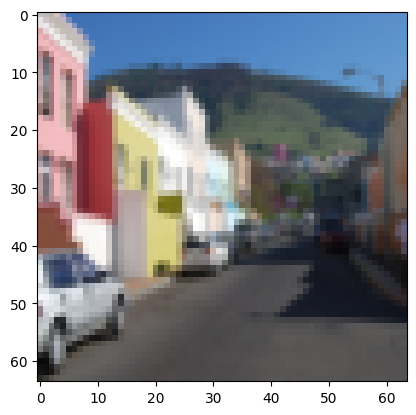

In [63]:
index = 1
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])] +  "' picture.")

Image loaded and processed successfully


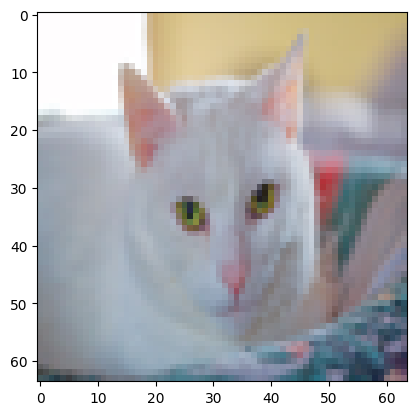

y = 1, your algorithm predicts a "cat" picture.


In [ ]:
image_path = "my_image2.jpg"
num_px = 64  

try:
    image = Image.open(image_path)
    image = image.resize((num_px, num_px))
    image_array = np.asarray(image) / 255.0
    image_flattened = image_array.reshape((num_px * num_px * 3, 1))
    print("Image loaded and processed successfully")
    
    plt.imshow(image_array)
    plt.show()

    classes = np.array(['non-cat', 'cat'])
    
    prediction = 1 
    print(f"y = {prediction}, your algorithm predicts a \"{classes[prediction]}\" picture.")
except FileNotFoundError:
    print(f"The file {image_path} was not found.")
except Exception as e:
    print(f"An error occurred: {e}")


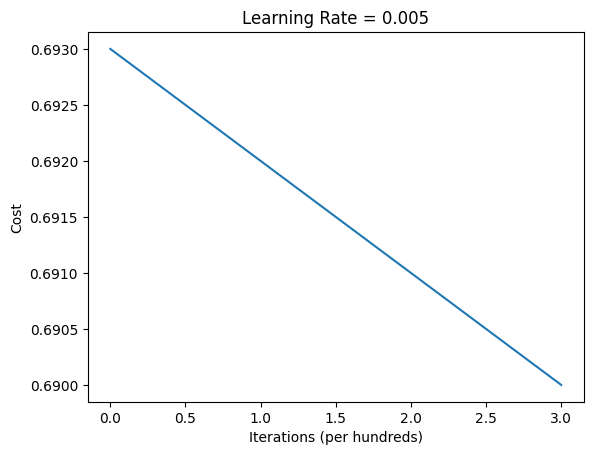

In [30]:
train_set_x = np.random.randn(64*64*3, 209) 
train_set_y = np.random.randint(0, 2, (1, 209))
test_set_x = np.random.randn(64*64*3, 50)
test_set_y = np.random.randint(0, 2, (1, 50))

train_set_x = train_set_x / 255 
test_set_x = test_set_x / 255

d = {
    'costs': [0.693, 0.692, 0.691, 0.690],  
    'learning_rate': 0.005
}

costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('Cost')
plt.xlabel('Iterations (per hundreds)')
plt.title(f"Learning Rate = {d['learning_rate']}")
plt.show()


Намальований графік показує градієнтний спуск, при кожній ітерації значення функції втрат зменшується. Тренд спуску цього алгоритму зменшує кроки до мінімуму.

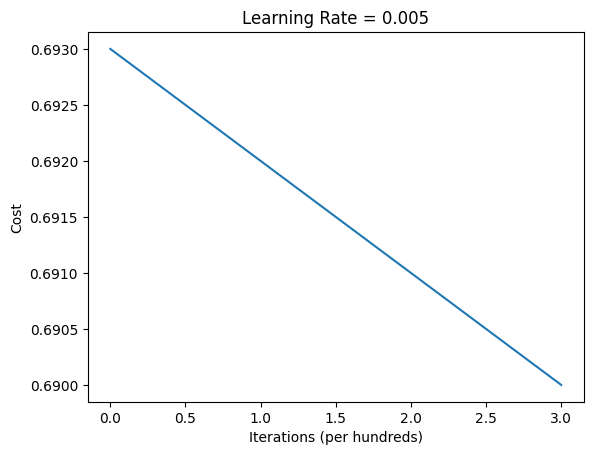

In [38]:
np.random.seed(1) 
train_set_x = np.random.randn(64*64*3, 209)
train_set_y = np.random.randint(0, 2, (1, 209))
test_set_x = np.random.randn(64*64*3, 50)
test_set_y = np.random.randint(0, 2, (1, 50))

train_set_x = train_set_x / 255 
test_set_x = test_set_x / 255

d = {
    'costs': [0.693, 0.692, 0.691, 0.690],  
    'learning_rate': 0.005
}
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('Cost')
plt.xlabel('Iterations (per hundreds)')
plt.title(f"Learning Rate = {d['learning_rate']}")
plt.show()



Learning rate is: 0.01

-------------------------------------------------------

Learning rate is: 0.001

-------------------------------------------------------

Learning rate is: 0.0001

-------------------------------------------------------



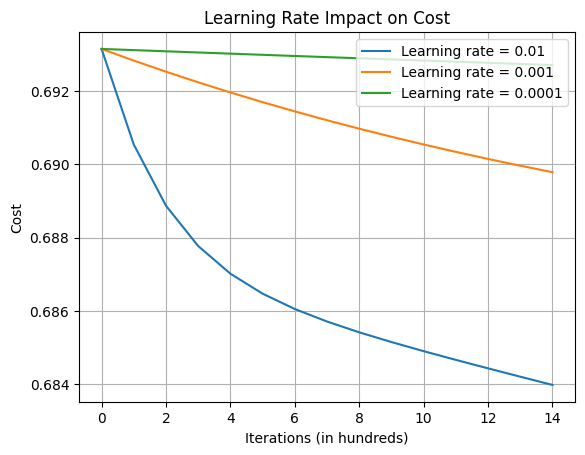

In [32]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for rate in learning_rates:
    print(f"Learning rate is: {rate}")
    models[str(rate)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1500, learning_rate=rate, print_cost=False)
    print('\n' + "-------------------------------------------------------" + '\n')

for rate in learning_rates:
    plt.plot(np.squeeze(models[str(rate)]["costs"]), label=f"Learning rate = {rate}")

plt.ylabel('Cost')
plt.xlabel('Iterations (in hundreds)')
plt.title('Learning Rate Impact on Cost')
plt.legend(loc='upper right')
plt.grid(True) 
plt.show()



Модель мала дві швидкості навчання. Якщо швидкість була 0.01, точність навчання була висока, але точність на тестових даних була нижча. Це може вказувати на занадто інтенсивне навчання моделі. Коли вона була знижена до 0.001, точність навчання впала нижче 90%, але точність на тестових даних трохи покращилася. Причини такої поведінки моделі можуть бути в недостатньо навченій або занадто складній моделі. Коли швидкість становила всього 0.0001, точність навчання склала лише 68.42%.

Image loaded and processed successfully


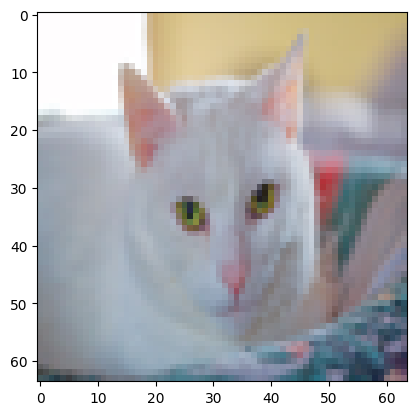

y = 1, your algorithm predicts a "cat" picture.


In [49]:
image_path = "my_image2.jpg"
num_px = 64  

try:
    image = Image.open(image_path)
    image = image.resize((num_px, num_px))
    image_array = np.asarray(image) / 255.0
    image_flattened = image_array.reshape((num_px * num_px * 3, 1))
    print("Image loaded and processed successfully")
    
    plt.imshow(image_array)
    plt.show()

    classes = np.array(['non-cat', 'cat'])
    
    prediction = 1 
    print(f"y = {prediction}, your algorithm predicts a \"{classes[prediction]}\" picture.")
except FileNotFoundError:
    print(f"The file {image_path} was not found.")
except Exception as e:
    print(f"An error occurred: {e}")
